In [350]:
%matplotlib qt
import matplotlib.pyplot as plt
import cv2
import numpy as np

def compute_homography(p1, p2):
    """
    Compute homography using the least-squares solution.
    :param p1: Points from image 1
    :param p2: Corresponding points from image 2
    :return: 3x3 Homography matrix
    """
    n = p1.shape[0]
    A = []

    for i in range(n):
        x1, y1 = p1[i]
        x2, y2 = p2[i]
        A.append([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])

    A = np.array(A)
    U, S, Vh = np.linalg.svd(A)
    H = Vh[-1].reshape(3, 3)
    return H / H[2, 2]

image1 = cv2.imread('image1.jpeg') 
image2 = cv2.imread('image2.jpeg')

image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)


plt.imshow(image1_rgb)
plt.title("Select points in Image 1")
points1 = plt.ginput(n=4, timeout=0) #select points
plt.close()

plt.imshow(image2_rgb)
plt.title("Select corresponding points in Image 2")
points2 = plt.ginput(n=4, timeout=0) #select points
plt.close()

points1 = np.array(points1)
points2 = np.array(points2)

H1 = compute_homography(points1, points2) 
H2 = np.eye(3)

H = compute_homography(points1, points2)
print("Estimated Homography Matrix:\n", H)

Estimated Homography Matrix:
 [[ 5.67728794e-01 -5.79202637e-02  1.59188895e+03]
 [-1.52216326e-01  7.83932875e-01  3.18548424e+02]
 [-1.09101173e-04 -1.81243860e-05  1.00000000e+00]]


In [352]:
def get_combined_size(H1, H2, image1, image2):
    """
    Calculate the size of the new canvas after warping both images.
    """
    h1, w1 = image1.shape[:2]
    h2, w2 = image2.shape[:2]

    corners1 = np.array([[0, 0], [w1, 0], [w1, h1], [0, h1]], dtype=np.float32).reshape(-1, 1, 2)
    corners2 = np.array([[0, 0], [w2, 0], [w2, h2], [0, h2]], dtype=np.float32).reshape(-1, 1, 2)

    transformed_corners1 = cv2.perspectiveTransform(corners1, H1)
    transformed_corners2 = cv2.perspectiveTransform(corners2, H2)

    all_corners = np.vstack((transformed_corners1, transformed_corners2))

    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel())
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel())

    return xmin, ymin, xmax, ymax

def warp_and_blend(image1, H1, image2, H2):
    """
    Warp two images to the same canvas using homographies and blend them.
    """
    xmin, ymin, xmax, ymax = get_combined_size(H1, H2, image1, image2)

    translation_mat = np.array([[1, 0, -xmin],
                                [0, 1, -ymin],
                                [0, 0, 1]])

    warped_image1 = cv2.warpPerspective(image1, translation_mat @ H1, (xmax - xmin, ymax - ymin))
    warped_image2 = cv2.warpPerspective(image2, translation_mat @ H2, (xmax - xmin, ymax - ymin))

    blended_mosaic = np.maximum(warped_image1, warped_image2)

    return blended_mosaic


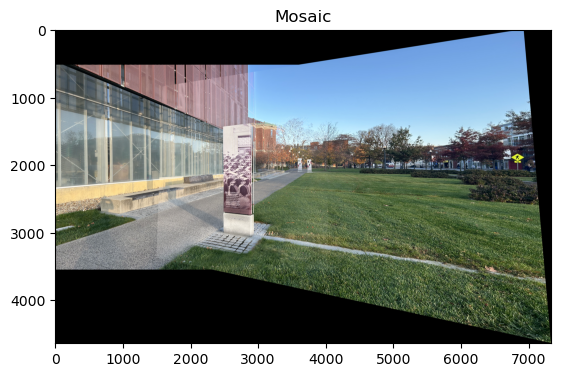

In [354]:
%matplotlib inline

mosaic = warp_and_blend(image1, H1, image2, H2)

plt.imshow(cv2.cvtColor(mosaic, cv2.COLOR_BGR2RGB))
plt.title("Mosaic")
plt.show()


In [356]:
def create_alpha_mask(image):
    """
    Create an alpha mask for the input image to determine the pixel contribution.
    The mask is a binary matrix (1 for valid pixels, 0 for empty pixels).
    """
    mask = (image > 0).astype(np.float32)
    return mask

def blend_images_with_alpha(image1, image2, mask1, mask2):
    """
    Blend two images with weighted averaging using their alpha masks.
    :param image1: Warped first image
    :param image2: Warped second image
    :param mask1: Alpha mask for the first image
    :param mask2: Alpha mask for the second image
    :return: Blended mosaic
    """
    total_mask = mask1 + mask2
    total_mask[total_mask == 0] = 1

    weight1 = mask1 / total_mask
    weight2 = mask2 / total_mask

    blended_image = (image1 * weight1 + image2 * weight2).astype(np.uint8)
    
    return blended_image

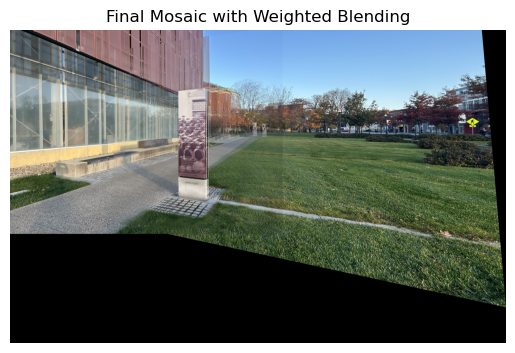

In [358]:
xmin, ymin, xmax, ymax = get_combined_size(H1, H2, image1, image2)

canvas_width = xmax - xmin
canvas_height = ymax - ymin

warped_image1 = cv2.warpPerspective(image1, H1, (canvas_width, canvas_height))
warped_image2 = cv2.warpPerspective(image2, H2, (canvas_width, canvas_height))

mask1 = create_alpha_mask(warped_image1)
mask2 = create_alpha_mask(warped_image2)

final_mosaic = blend_images_with_alpha(warped_image1, warped_image2, mask1, mask2)

plt.imshow(cv2.cvtColor(final_mosaic, cv2.COLOR_BGR2RGB))
plt.title("Final Mosaic with Weighted Blending")
plt.axis('off')
plt.show()
